# Vegetation Phenology <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops, or how the growing seasons of native vegetation are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects).

## Description

This notebook demonstrates how to calculate vegetation phenology statistics using the DEA function [xr_phenology](../Scripts/dea_temporal.py).  
To detect changes in plant life for Sentinel-2, the script uses either the **Normalized Difference Vegetation Index (NDVI)** or the **Enhanced Vegetation Index (EVI)**, which are common proxies for vegetation growth and health.

The outputs of this notebook can be used to assess spatio-temporal differences in the growing seasons of agriculture fields or native vegetation.

This notebook demonstrates the following steps:

1. Load cloud-masked Sentinel-2 data for an area of interest.
2. Calculate a vegetation proxy index (NDVI or EVI).
3. Generate a zonal time series of vegetation health.
4. Complete and smooth the vegetation timeseries to remove gaps and noise.
5. Calculate phenology statistics on a simple 1D vegetation time series.
6. Calculate per-pixel phenology statistics.
7. Optional: Calculating generic temporal statistics usng the [hdstats](https://github.com/daleroberts/hdstats/blob/master/hdstats/ts.pyx) library.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import datetime as dt
import os

sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_plotting import display_map, rgb
import dea_temporal

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')

### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2019-06')`).



In [3]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'

# Define area of interest
lat = -33.3631
lon = 121.2050
lon_buffer = 0.023
lat_buffer = 0.0075

# Set the range of dates for the analysis
time_range = ('2019-03', '2019-12')

In [4]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [6]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:3577',
    'group_by': 'solar_day'
}

# Load available data from Landsat 8
ds = load_ard(
    dc=dc,
    products=['s2a_ard_granule', 's2b_ard_granule'],
    min_gooddata=0.75,
    **query,
)

print(ds)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 53 out of 105 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Loading 53 time steps
<xarray.Dataset>
Dimensions:      (time: 53, x: 220, y: 102)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 -9.991e+05 -9.991e+05 ... -9.948e+05 -9.948e+05
  * y            (y) float64 -3.681e+06 -3.681e+06 ... -3.683e+06 -3.683e+06
  * time         (time) datetime64[ns] 2019-03-02T01:56:21.024000 ... 2019-11...
Data variables:
    nbart_red    (time, y, x) float32 1625.0 1614.0 1680.0 ... 1788.0 1748.0
    nbart_green  (time, y, x) float32 1241.0 1220.0 1247.0 ... 1306.0 1308.0
    nbart_blue   (time, y, x) float32 1024.0 1006.0 1050.0 ... 1034.0 993.0
    nbart_nir_1  (time, y, x) float32 2244.0 2245.0 2335.0 ... 2441.0 2402.0
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref


**Once the load is complete**, we can plot some of the images as as a true-colour image using the `rgb` function.  

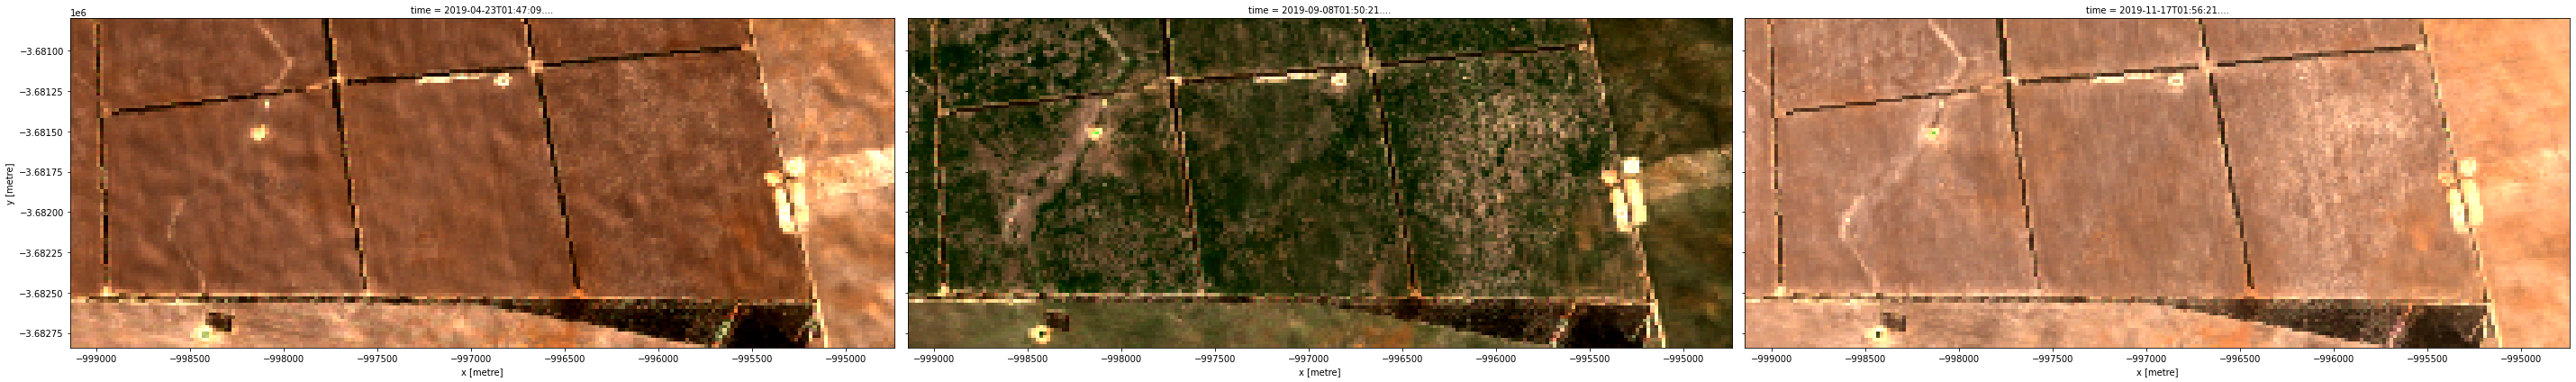

In [7]:
rgb(ds, index=[4, 35, 50], col_wrap=3)

## Compute band indices

This study measures the presence of vegetation through either the `normalised difference vegetation index (NDVI)` or the `enhanced vegetation index (EVI)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Enhanced Vegetation Index requires the `red`, `nir` and `blue` bands.
The formula is

$$
\begin{aligned}
\text{EVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$


Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [dea_bandindices.py](../Scripts/dea_bandindices.py).
Here, we use `collection='ga_s2_1'` since we're working with Sentinel-2 data.

In [8]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=veg_proxy, collection='ga_s2_1')

# Save the NDVI to the dask cluster
ds[veg_proxy] = ds[veg_proxy]

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  


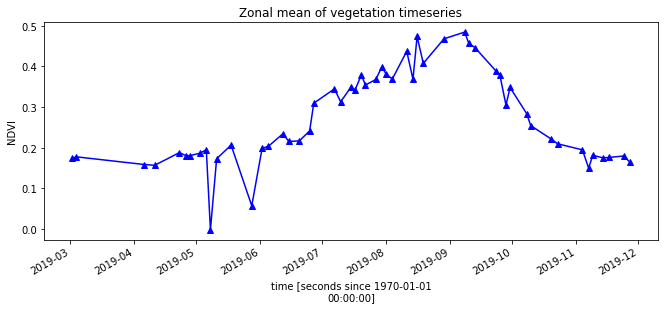

In [9]:
ds[veg_proxy].mean(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Zonal mean of vegetation timeseries');

## Interpolate vegetation time-series

Due to the infrequency of satellite passes or the presence of cloud obscuring the ground, our data may have gaps. 
`Xarray` has inbuilt methods such as `.interpolate_na()` to complete a time-series.
While these functions are great for small datasets, they can become prohibitively slow at scale. DEA's custom function `fast_completion` will remove any `NaNs` (Not a Number) very quickly, even over relatively large datasets. 

We will test both methods below.

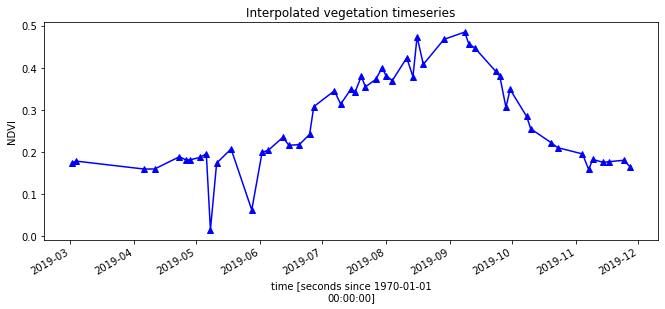

In [10]:
# Fill missing values using xarray's interpolate_na() method
ds[veg_proxy].interpolate_na(dim='time', method='linear').mean(['x', 'y']).plot.line('b-^', figsize=(11, 4))

plt.title('Interpolated vegetation timeseries');

Alternatively, lets complete the timeseries using the DEA function `dea_temporal.fast_complete()`

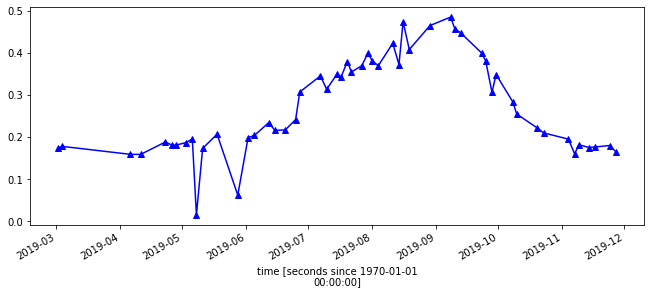

In [11]:
# Complete timeseries using fast_completion
veg = dea_temporal.fast_completion(ds[veg_proxy])

# Plot the result
veg.mean(['x', 'y']).plot.line('b-^', figsize=(11, 4));

## Smoothing vegetation time-series

We may also wish to smooth a time series to remove noise. This can be accomplished in a number of ways, two of which we explore here.
1. By calculating a `xarray.rolling mean()` over a specified window-size. 
2. By applying the `dea_temporal.smooth()` function, which relies on the `scipy.signal.wiener` filter.

Below we will demonstrate this by first calculating a `rolling mean` across every three time steps. 
The larger the window-size, the smoother the curve will be, but at the cost of more granular detail in the curve.

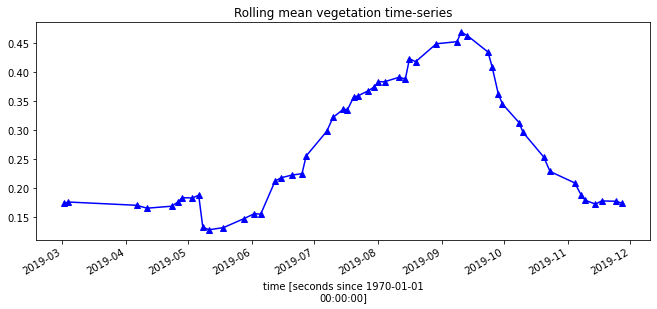

In [12]:
# Smooth the data
veg_rolling = veg.mean(['x', 'y']).rolling(time=3, min_periods=1).mean()

# Plot the smoothed data
veg_rolling.plot.line('b-^', figsize=(11, 4))
plt.title('Rolling mean vegetation time-series');

 Alternatively, lets smooth the timeseries using `dea_temporal.smooth()`:

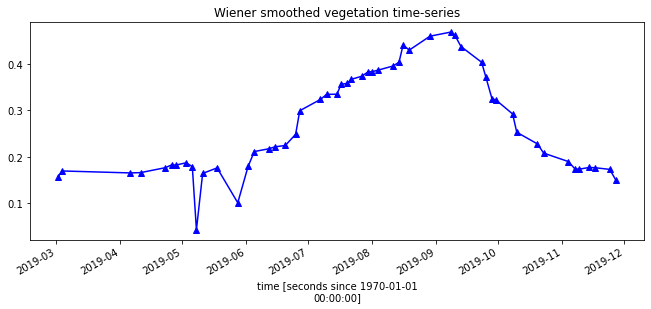

In [13]:
# Smooth the data
veg_smooth = dea_temporal.smooth(veg)

# Plot the smoothed data
veg_smooth.mean(['x', 'y']).plot.line('b-^', figsize=(11, 4))
plt.title('Wiener smoothed vegetation time-series');

## Calculate phenology statistics using `xr_phenology`

The DEA function `xr_phenology` can calculate a number of land-surface phenology statistics that together describe the characteristics of a plant's lifecycle.  
The function can calculate the following statistics on either a zonal timeseries (like the one above), or on a per-pixel basis:

            SOS = DOY of start of season
            POS = DOY of peak of season
            EOS = DOY of end of season
            vSOS = Value at start of season
            vPOS = Value at peak of season
            vEOS = Value at end of season
            Trough = Minimum value of season
            LOS = Length of season (DOY)
            AOS = Amplitude of season (in value units)
            ROG = Rate of greening
            ROS = Rate of senescence

where DOY = day-of-year (Jan 1st = 0, Dec 31st = 365).  
By default the function will return all the statistics as an `xarray.Dataset`, to return only a subset of these statistics pass a list of the desired statistics to the function e.g. `stats=['SOS', 'EOS', 'ROG']`.

The `xr_phenology` function also allows for interpolating and/or smoothing the time-series in the same way as we did above, the interpolating/smoothing will occur before the statistics are calculated. 

See the [dea_temporal](../Scripts/dea_temporal.py) script for more information on each of the parameters in `xr_phenology`.


### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal mean (mean of all pixels in the image) time-series to the function and plot the results on the same curves as above.

In [14]:
# Calculate phenology on the zonal mean of the dataset
zonal_phen = dea_temporal.xr_phenology(
    ds.NDVI.mean(['x', 'y']),
    stats=['SOS', 'POS', 'EOS', 'vSOS', 'vPOS', 'vEOS'],
    method_sos="median",
    method_eos="median",
    complete="linear",
    smoothing="rolling_mean")

print(zonal_phen)

Completing using linear interp...
   Smoothing with rolling mean...
      Phenology...
         POS
         EOS
         vSOS
         vPOS
         vEOS
<xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 3577
Data variables:
    SOS          int16 171
    POS          int16 253
    EOS          int16 293
    vSOS         float32 0.22170618
    vPOS         float32 0.46965763
    vEOS         float32 0.2528491


Plot the results with our statistcs annotated on the plot

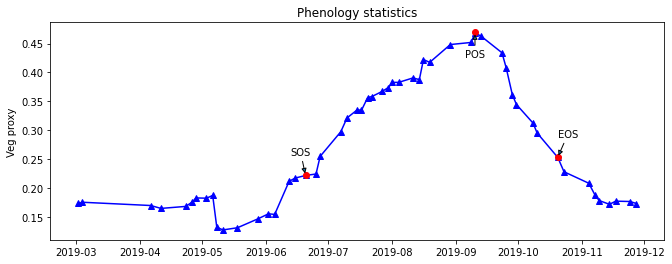

In [15]:
# Use DOY results to create a datetime object
year = str(ds.time.dt.year.values[0]) + " "
eos_dt = dt.datetime.strptime(year + str(zonal_phen.EOS.values), '%Y %j')
sos_dt = dt.datetime.strptime(year + str(zonal_phen.SOS.values), '%Y %j')
pos_dt = dt.datetime.strptime(year + str(zonal_phen.POS.values), '%Y %j')

# Create plot
fig, ax = plt.subplots(figsize=(11, 4))
ax.plot(veg_rolling.time, veg_rolling, 'b-^')

# Add start of season
ax.plot(sos_dt, zonal_phen.vSOS, 'or')
ax.annotate('SOS',
            xy=(sos_dt, zonal_phen.vSOS.values),
            xytext=(-15, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

# Add end of season
ax.plot(eos_dt, zonal_phen.vEOS, 'or')
ax.annotate('EOS',
            xy=(eos_dt, zonal_phen.vEOS.values),
            xytext=(0, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

# Add peak of season
ax.plot(pos_dt, zonal_phen.vPOS, 'or')
ax.annotate('POS',
            xy=(pos_dt, zonal_phen.vPOS.values),
            xytext=(-10, -25),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='-|>'))

plt.ylabel('Veg proxy')
plt.title('Phenology statistics');

### Per-pixel phenology statistics

We can now calculate the statistics for every pixel in our time-series and plot the results. 
In the code below we have changed the `method_eos` and `method_sos` parameters to `'median'`, this will estimate the beginning and end of the growing seasons as the median value of the slopes on the each side of the curve. 
The code below also demonstrates using the `fast_complete` and `wiener` methods for gap-filling and smoothing.

In [16]:
# Calculate phenology stats on every pixel in dataset
phen = dea_temporal.xr_phenology(ds.NDVI,
                                 method_sos='median',
                                 method_eos='median',
                                 complete='linear',
                                 smoothing='rolling_mean').compute()

print(phen)

Completing using linear interp...
   Smoothing with rolling mean...
      Phenology...
         POS
         EOS
         Trough
         vSOS
         vPOS
         vEOS
         LOS
         AOS
         ROG
         ROS
<xarray.Dataset>
Dimensions:      (x: 220, y: 102)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 -9.991e+05 -9.991e+05 ... -9.948e+05 -9.948e+05
  * y            (y) float64 -3.681e+06 -3.681e+06 ... -3.683e+06 -3.683e+06
Data variables:
    SOS          (y, x) int16 178 166 166 166 166 163 131 ... 61 61 63 176 61 63
    POS          (y, x) int16 231 256 253 253 253 228 ... 253 253 253 253 253
    EOS          (y, x) int16 283 296 293 293 293 283 ... 293 293 293 293 293
    Trough       (y, x) float32 0.13168094 0.13913259 ... 0.102451846 0.10578366
    vSOS         (y, x) float32 0.21645823 0.22310893 ... 0.17082627 0.16573206
    vPOS         (y, x) float32 0.35689276 0.41015622 ... 0.52073646 0.51606786
    vEOS         (y, x) float32 0.234

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

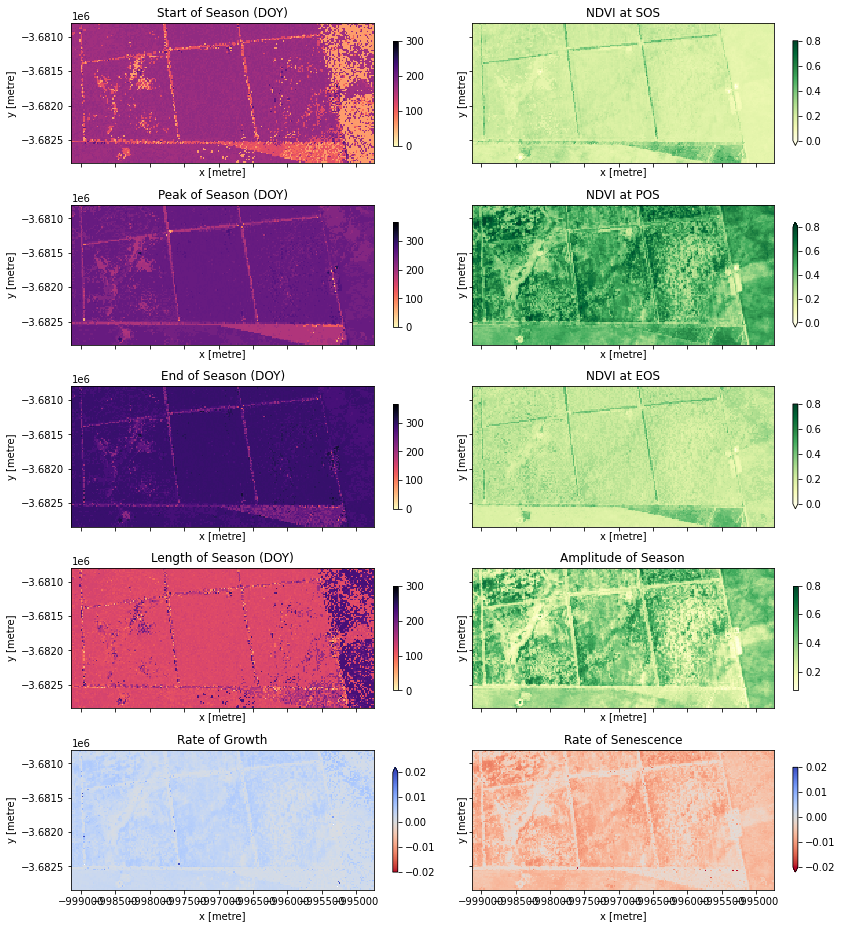

In [17]:
# Set up figure
fig, ax = plt.subplots(nrows=5,
                       ncols=2,
                       figsize=(12, 13),
                       sharex=True,
                       sharey=True)

# Set colorbar size
cbar_size = 0.7

# Set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# Start of season
phen.SOS.plot(ax=ax[0, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 0].set_title('Start of Season (DOY)')
phen.vSOS.plot(ax=ax[0, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title(veg_proxy + ' at SOS')

# Peak of season
phen.POS.plot(ax=ax[1, 0],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title('Peak of Season (DOY)')
phen.vPOS.plot(ax=ax[1, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 1].set_title(veg_proxy + ' at POS')

# End of season
phen.EOS.plot(ax=ax[2, 0],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[2, 0].set_title('End of Season (DOY)')
phen.vEOS.plot(ax=ax[2, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[2, 1].set_title(veg_proxy + ' at EOS')

# Length of Season
phen.LOS.plot(ax=ax[3, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[3, 0].set_title('Length of Season (DOY)')

# Amplitude
phen.AOS.plot(ax=ax[3, 1],
              cmap='YlGn',
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[3, 1].set_title('Amplitude of Season')

# Rate of growth
phen.ROG.plot(ax=ax[4, 0],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[4, 0].set_title('Rate of Growth')

# Rate of Sensescence
phen.ROS.plot(ax=ax[4, 1],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[4, 1].set_title('Rate of Senescence')

plt.tight_layout();

## Advanced: Calculating generic temporal statistics

In addition to the `xr_phenology` function, the DEA [dea_temporal](../Scripts/dea_temporal.py) script contains another function for calculating generic time-series statistics, `temporal_statistics`.  This function is built upon the [hdstats library](https://github.com/daleroberts/hdstats) (a library of multivariate and high-dimensional statistics algorithms).
This function accepts a 2 or 3D time-series of, for example, NDVI, and computes a number of summary statistics including:
- discordance
- discrete fourier transform coefficients (mean, std, and median)
- median change
- absolute change
- complexity
- central difference
- number of peaks (this function is very slow to run)

Below we will calculate a number of these statistics and plot them.

In [18]:
statistics = [
    'discordance', 'f_mean', 'median_change', 'abs_change', 'complexity',
    'central_diff'
]

ts_stats = dea_temporal.temporal_statistics(ds[veg_proxy], statistics)
print(ts_stats)

Completing...
   Statistics:
      discordance
      f_mean
      median_change
      abs_change
      complexity
      central_diff
<xarray.Dataset>
Dimensions:        (x: 220, y: 102)
Coordinates:
  * x              (x) float64 -9.991e+05 -9.991e+05 ... -9.948e+05 -9.948e+05
  * y              (y) float64 -3.681e+06 -3.681e+06 ... -3.683e+06 -3.683e+06
Data variables:
    discordance    (y, x) float32 -0.039235786 -0.011582604 ... -0.018823942
    f_mean_n1      (y, x) float32 0.7779196 1.0193269 ... 1.3496052 1.3903135
    f_mean_n2      (y, x) float32 0.29275426 0.2851077 ... 0.18160981 0.16082169
    f_mean_n3      (y, x) float32 0.16647191 0.17777616 ... 0.29130608 0.249685
    median_change  (y, x) float32 -0.002159074 -0.0021759272 ... -0.0016208887
    abs_change     (y, x) float32 0.028381627 0.029113255 ... 0.03790364
    complexity     (y, x) float32 19.472597 11.5116205 ... 9.227929 9.313293
    central_diff   (y, x) float32 -0.0002451523 -0.000122999 ... -7.471574e-05


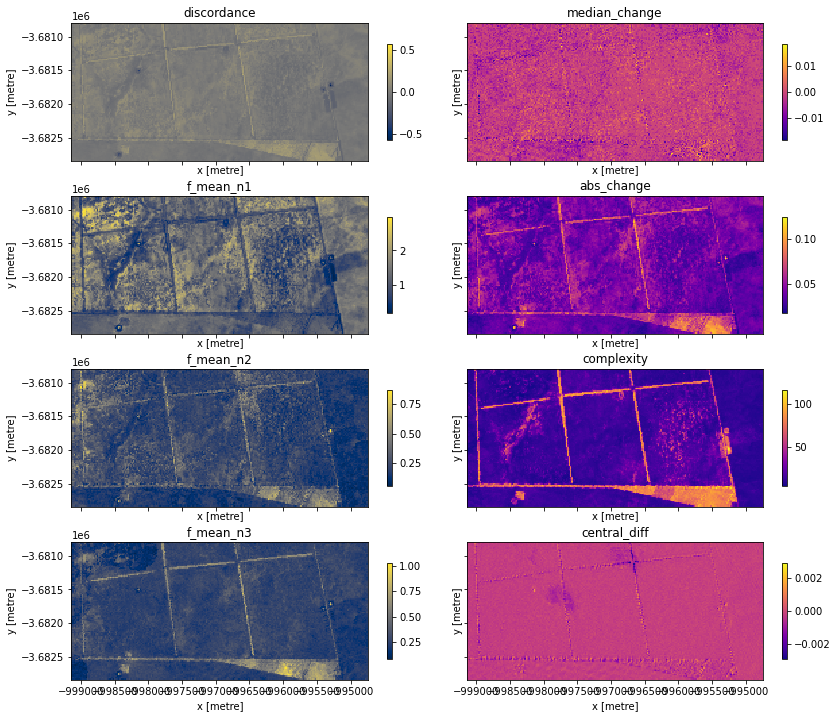

In [19]:
# Set up figure
fig, axes = plt.subplots(nrows=4,
                         ncols=2,
                         figsize=(12, 10),
                         sharex=True,
                         sharey=True)

# Set colorbar size
cbar_size = 0.5

# Set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# Set colorbar size
cbar_size = 0.7
stats = list(ts_stats.data_vars)

# Plot
for ax, stat_1, stat_2 in zip(axes, stats[0:4], stats[4:8]):
    ts_stats[stat_1].plot(ax=ax[0],
                          cmap='cividis',
                          cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[0].set_title(stat_1)

    ts_stats[stat_2].plot(ax=ax[1],
                          cmap='plasma',
                          cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[1].set_title(stat_2)

plt.tight_layout();

## Conclusions

In the example above, we can see these four fields are following the same cropping schedule and are therefore likely the same species of crop. 
We can also observe intra-field differences in the rates of growth, and in the NDVI values at different times of the season, which may be attributable to differences in soil quality, watering intensity, or other farming practices. 

Phenology statistics are a powerful way to summarise the seasonal cycle of a plant's life.  
Per-pixel plots of phenology can help us understand the timing of vegetation growth and sensecence across large areas and across diverse plant species as every pixel is treated as an independent series of observations. 
This could be important, for example, if we wanted to assess how the growing seasons are shifting as the climate warms.  


## Next steps

When you're done, if you wish to run this code for another region, return to the "Analysis parameters" cell, modify some values (e.g. `time_range`,  or `lat`/`lon`) and rerun the analysis.

For advanced users, `xr_phenology` could be used for generating phenology feature layers in a machine learning classifier (see [Machine Learning with ODC](../Frequently_used_code/Machine_learning_with_ODC.ipynb) for example of running ML models with ODC data). 
`xr_phenology` can be passed inside of the `custom_func` parameter in the `dea_classificationtools.collect_training_data()` function, allowing phenological statistics to be computed during the collection of training data. 
An example would look like this:

    import sys
    sys.path.append('../Scripts')
    from dea_temporal_statistics import xr_phenology
    from dea_classificationtools import collect_training_data

    def phenology_stats(da):
        stats = xr_phenology(da, complete='fast_complete')
        return stats

    training = collect_training_data(...,
                                     custom_func=phenology_stats)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [20]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)